# Import

In [448]:
import numpy as np
import torch
import sys
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
import itertools
sys.path.append(os.getcwd()+'/../')
import lfi
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)
torch.set_grad_enabled(False)
sys.path.append('../methods/Res_Net')
from model import Model

In [449]:
ns_total = np.array([1600000, 1300000, 1000000, 700000, 400000, 200000, 100000, 50000, 30000, 20000, 10000, 6000, 4500, 3000, 2000, 1000, 500, 200, 100])
# ns_total = np.array([ 400000, 200000, 100000, 50000, 30000, 10000, 6000, 4500, 3000, 1000])
# NN = 20; kk = 0
ms_total = 10**np.linspace(2, 7, 26)
ms_total = ms_total.astype(int)

# Load Data

In [450]:
df_raw = pd.DataFrame(columns=['n', 'm', 'type1_repeats', 'type2_repeats', 'error_repeats'])
for model_id in range(20):
    for n in ns_total+model_id:
        try:
            type1_repeats = np.load('../methods/Res_Net/checkpoints/n_tr=%d/type_1_error.npy'%n)
            type2_repeats = np.load('../methods/Res_Net/checkpoints/n_tr=%d/type_2_error.npy'%n)
            if type(type1_repeats)==np.lib.npyio.NpzFile:
                continue
            if type1_repeats.shape[1]!=10:
                raise ValueError('type1_repeats.shape[1]!=10')
        except:
            continue
        # print(type1_repeats, type2_repeats)
        for j,m in tqdm(enumerate(ms_total), leave=False, desc='n=%d'%n): 
            df_raw = df_raw.append({'n': n, 
                            'm': m, 
                            'type1_repeats': type1_repeats[j,:], 
                            'type2_repeats':type2_repeats[j,:], 
                            'error_repeats': np.mean(type1_repeats[j,:])+np.mean(type2_repeats[j,:])
                            }, ignore_index=True)
        clear_output(wait=False)

In [451]:
df = pd.DataFrame(columns=['n', 'm', 'error_ids_repeats', 'error_trails', 'train_times'])
def get_m_n_mat_from_df(df, n, m):
    error_list_of_array = df_raw[(df_raw['n']>=n) & (df_raw['n']<=n+20) & (df_raw['m']==m)]['error_repeats']
    mat = np.zeros((len(error_list_of_array), 10))
    for i in range(len(error_list_of_array)):
        mat[i,:] = error_list_of_array.iloc[i]
    return mat
for n in ns_total:
    for m in ms_total:
        mat = get_m_n_mat_from_df(df_raw, n, m)
        df = df.append({'n': n, 'm':m,
                    'error_ids_repeats': mat,
                    'error_trails': np.mean(mat, axis=1),
                    'train_times': mat.shape[0]
                    }, ignore_index=True)
        clear_output(wait=False)
    


# Plot

In [452]:
ms_total, ns_total

(array([     100,      158,      251,      398,      630,     1000,
            1584,     2511,     3981,     6309,    10000,    15848,
           25118,    39810,    63095,   100000,   158489,   251188,
          398107,   630957,  1000000,  1584893,  2511886,  3981071,
         6309573, 10000000]),
 array([1600000, 1300000, 1000000,  700000,  400000,  200000,  100000,
          50000,   30000,   20000,   10000,    6000,    4500,    3000,
           2000,    1000,     500,     200,     100]))

## 这里

In [453]:
def get_list_from_n_m(n, m):
    row = df[(df['n']==n) & (df['m']==m)]
    return row.loc[row.index.to_list()[0], 'error_trails']
def clean(A):
    C = np.log10(-np.log10(A))
    B = (C-np.mean(C))/np.std(C)
    B = np.abs(B)
    A = A[B<2]
    return A
Type12_mat = np.zeros((len(ns_total), len(ms_total)))
for i,n in enumerate(ns_total):
    for j,m in enumerate(ms_total):
        # print('-- ', n, m, mat, '--')
        if len(mat)==0:
            Type12_mat[i,j] = 0
            continue
        else:
            # print(row['error_ids_repeats'])
            A = get_list_from_n_m(n, m)
            # A = clean(A)
            Type12_mat[i,j] = np.mean(A)
            # if n==100000 and m<80000:
                # Type12_mat[i,j] = (np.sum(A)-np.max(A)-np.min(A))/(len(A)-2)
            # if n==100000 and m>800000:
Times_mat = np.zeros((len(ns_total), len(ms_total)))
for i,n in enumerate(ns_total):
    for j,m in enumerate(ms_total):
        row = df[(df['n']==n) & (df['m']==m)]
        Times_mat[i,j] = row.loc[row.index.to_list()[0], 'train_times']

## 每个 m n 几次

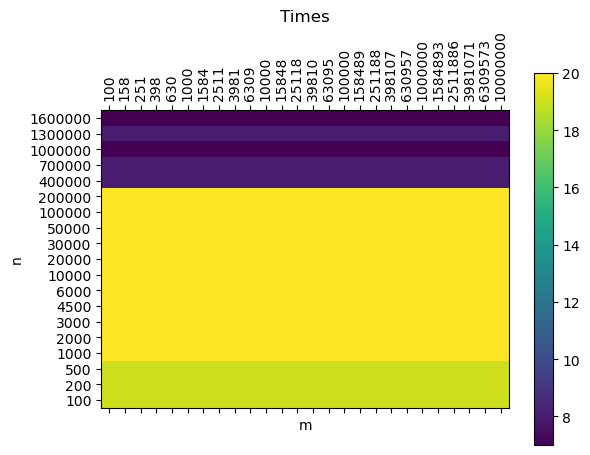

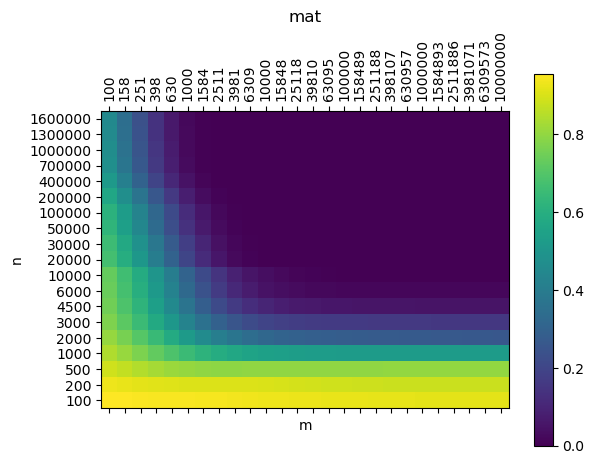

In [454]:
plt.matshow(Times_mat)
# label mn
plt.xticks(np.arange(len(ms_total)), ms_total, rotation=90)
plt.yticks(np.arange(len(ns_total)), ns_total)
plt.xlabel('m')
plt.ylabel('n')
plt.colorbar()
plt.title('Times')
plt.show()

plt.matshow(Type12_mat)
plt.xticks(np.arange(len(ms_total)), ms_total, rotation=90)
plt.yticks(np.arange(len(ns_total)), ns_total)
plt.xlabel('m')
plt.ylabel('n')
plt.colorbar()
plt.title('mat')
plt.show()


## 看特殊的 m n


In [455]:
get_list_from_n_m(100000, ms_total[10])

array([3.22511850e-05, 2.17294374e-05, 3.09351327e-05, 5.96864420e-03,
       1.97175775e-05, 2.31088465e-04, 1.83938597e-05, 8.14125926e-05,
       4.62959972e-05, 5.50991007e-05, 4.39719804e-05, 7.74126890e-05,
       9.75525039e-05, 2.87726844e-06, 7.16842227e-05, 1.57253094e-04,
       6.47110404e-06, 1.52035082e-05, 2.64020238e-05, 4.44224188e-05])

In [456]:
from scipy.ndimage import gaussian_filter
Error_total = gaussian_filter(Type12_mat, sigma=.4)
# Type12_mat_log = -np.log10(-np.log10(Error_total))
# maxi = 1.5 # just to truncate the colorbar
# Type12_mat_log[Type12_mat_log>maxi]=maxi

[0.1        0.12845442 0.16057272 0.19590892 0.2339067  0.27394203
 0.31536447 0.35753323 0.39984607 0.44176023 0.48280553 0.52259074
 0.56080433 0.59721112 0.63164603 0.66400608 0.69424168 0.72234762
 0.74835465 0.77232155 0.79432823]


/tmp/ipykernel_1901479/846629084.py:5: RuntimeWarning: divide by zero encountered in log10
  Type12_mat_log = np.log10(Type12_mat)


Text(0.5, 1.0, 'Higgs experiment')

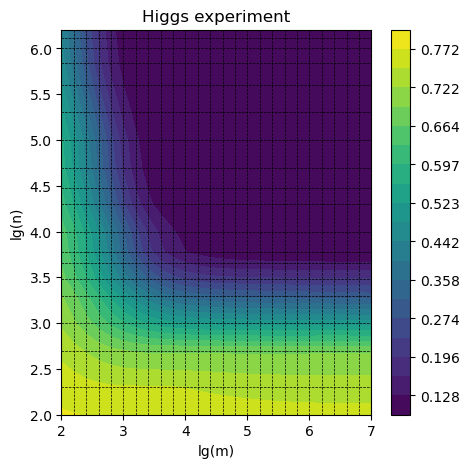

In [457]:
# Error_m_ntr_cat = np.concatenate((Error_m_ntr_M[:,0:30], Error_m_ntr_G[:,30:50]), axis=1)
fig = plt.figure(figsize=(5,5))
# plt.subplot(2,1,1)

Type12_mat_log = np.log10(Type12_mat)
contourf_ = plt.contourf(np.log10(ms_total), np.log10(ns_total), Error_total, levels=20)
cb = fig.colorbar(contourf_)
log_log_p_list = cb.mappable.levels # np.linspace(Type12_mat_log.min()+0.00001, Type12_mat_log.max()-0.000001, levels+1)
real_p_list = 10**(-(10**(-log_log_p_list)))
print(real_p_list)
real_p_list = np.around(real_p_list, decimals=3)
real_p_list = real_p_list.astype(str)
# real_p_list[1] = '$4.1\cdot 10^{-23}$'
# real_p_list[3] = '$6.0\cdot 10^{-12}$'
# real_p_list[5] = '$2.4\cdot 10^{-6}$'
# real_p_list[7] = '$1.0\cdot 10^{-4}$'
# real_p_list[9] = '0.010'
# real_p_list[11] = '0.100'

cb.set_ticks(log_log_p_list[1:-1:2])
cb.set_ticklabels(real_p_list[1:-1:2])

for nn in ns_total:
    plt.axhline(y=np.log10(nn), color='k', linestyle='--', linewidth=0.5)
for mm in ms_total:
    plt.axvline(x=np.log10(mm), color='k', linestyle='--', linewidth=0.5)

plt.xlabel('lg(m)')
plt.ylabel('lg(n)')
plt.title('Higgs experiment')

# Plot

In [458]:
import pickle
with open('Higgs_experiment.pkl', 'wb') as f:
    pickle.dump([ns_total, ms_total, Type12_mat], f)

In [459]:
from scipy.ndimage import gaussian_filter
t1 = 1e-15
t2 = 0.9
Type12_mat[Type12_mat<t1]=t1
Type12_mat[Type12_mat>t2]=t2
Error_total = Type12_mat
# Error_total = gaussian_filter(higgs_Z, sigma=0.1)
Type12_mat_log = -np.log10(-np.log10(Error_total))
# maxi = 1.5 # just to truncate the colorbar
# Type12_mat_log[Type12_mat_log>maxi]=maxi

[1.41601572e-16 6.02303597e-12 1.13950872e-08 2.38005366e-06
 1.04454774e-04 1.51920741e-03 1.01096864e-02 3.86778616e-02
 1.00000000e-01 1.95908922e-01 3.15364473e-01 4.41760225e-01
 5.60804328e-01 6.64006085e-01 7.48354645e-01 8.14469651e-01
 8.64777269e-01 9.02259868e-01]


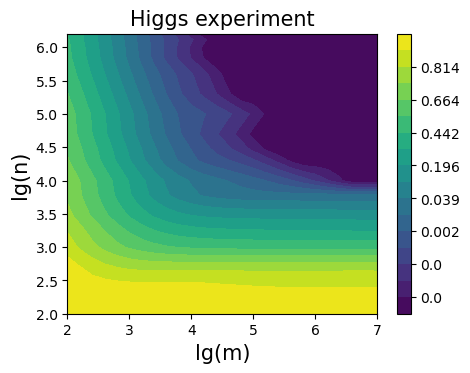

In [460]:
fig = plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
contourf_ = plt.contourf(np.log10(ms_total), np.log10(ns_total), Type12_mat_log, levels=20)
plt.xlabel('lg(m)', fontsize=15)
plt.ylabel('lg(n)', fontsize=15)
plt.title('Higgs experiment', fontsize=15)
#plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))
# plt.ylim(3,6.2)
# plt.xlim(2,5)
# plt.colorbar()
cb = fig.colorbar(contourf_)
log_log_p_list = cb.mappable.levels # np.linspace(Type12_mat_log.min()+0.00001, Type12_mat_log.max()-0.000001, levels+1)
real_p_list = 10**(-(10**(-log_log_p_list)))
print(real_p_list)
real_p_list = np.around(real_p_list, decimals=3)
real_p_list = real_p_list.astype(str)
# real_p_list[1] = '$4.1\cdot 10^{-23}$'
# real_p_list[3] = '$6.0\cdot 10^{-12}$'
# real_p_list[5] = '$2.4\cdot 10^{-6}$'
# real_p_list[7] = '$1.0\cdot 10^{-4}$'
cb.set_ticks(log_log_p_list[1:-1:2])
cb.set_ticklabels(real_p_list[1:-1:2])